## mDC proportion analysis - cell-cell communication to find differentially expressed interactions between mDC high samples and mDC low samples by cell subtypes

- Author: CW
- Files needed: cell_communication_analysis/2_significant_interactions_subtype, cell_communication_analysis/2_significant_interactions_subtype
- File outputs/for plots: mregDC_proportion_analysis/cell_communication_LR_results_subtype_no_zero_means.csv, mregDC_proportion_analysis/cell_communication_LR_results_subtype_w_zero_means.csv
- Last updated: 04/13/24

__Note__: cell-cell communication analysis was run with the subtype "mregDC" labeled as "mDC". The code may need to be modified to account for this. If there are discrepancies, mDC and mregDC are interchangable.

We want to test whether the differences from interaction expression are different between mregDC high and low samples. To adjust for covariates, we need to use a different model other than the Wilcoxon rank sum test. We can use logistic regression to model the outcome.  

In [1]:
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## 1. Collect all interactions by all pairs from every sample 

In [62]:
file_path <- '/home/cbw3/data/figure_generation/Figure6/cpdb_subtyped/2_significant_interactions_subtyped/'

In [63]:
ccc_results <- read.csv(paste0(file_path,'all_samples_subtypedall.tsv'), sep = '\t', 
                       row.names = 'X')

In [64]:
colnames(ccc_results)

[1] "interacting_pair"  "partner_a"         "partner_b"        
 [4] "gene_a"            "gene_b"            "receptor_a"       
 [7] "receptor_b"        "secreted"          "interacting_cells"
[10] "significant_mean"  "sample"

In [65]:
ccc_results_ixns <- ccc_results %>% select(c('interacting_pair', 'partner_a', 'partner_b', 
                         'interacting_cells'))
unique_ccc_results_ixns <- unique(ccc_results_ixns)

In [79]:
dim(unique_ccc_results_ixns)

[1] 198364      4

unique_ccc_results_ixns are the unique interactions across all samples and those that we will want to test across all samples

## 2. Gather metadata and covariates for each sample

In [68]:
clinical.metadata <- read.csv('/path_to_file/Supplementary_Table_1.csv', 
                             row.names = 'X')

In [69]:
colnames(clinical.metadata)

[1] "sample_ID_long"       "patient"              "uid"                 
 [4] "age"                  "sex"                  "subtype"             
 [7] "sample_date"          "treatment"            "treatment_group"     
[10] "adjuvant"             "ICI"                  "prior_therapy"       
[13] "state"                "pfs"                  "censure_pfs"         
[16] "os"                   "censure_os"           "tissue"              
[19] "notes_normal_primary" "in_retrospective"     "include"             
[22] "driver_mutations"     "BRAF"                 "NRAS"                
[25] "NF1"                  "TERT"                 "TP53.TP63"           
[28] "PTEN"                 "MAP2K1.MAP3K2"        "scRNA"               
[31] "snATAC"               "day_to_treatment"     "overall_response"    
[34] "response_short"       "with_ICI"             "ICI_only"            
[37] "mregDC_out_of_cDC"    "is_mregDC_high"       "mregDC_status"       
[40] "patient_sample"       "ATAC_sample_ID"

In [70]:
#take out 1122_1
clinical.metadata <- clinical.metadata[!clinical.metadata$patient_sample == '1122_1',]

In [71]:
#format the covariates before encoding into the design matrix 
#for with ICI samples - with ICI, ICI only, antiPD1
clinical.metadata$treatment_group_new <- "other"

clinical.metadata[clinical.metadata$treatment_group %in% c('ICI_PD1','ICI_combo', 'targeted_plus_ICI', 
                           'other_plus_ICI'),]$treatment_group_new <-  "with_ICI"

clinical.metadata[clinical.metadata$treatment_group %in% c('ICI_PD1','ICI_combo'),]$treatment_group_new <- "ICI_only"

clinical.metadata[clinical.metadata$treatment_group == 'ICI_PD1',]$treatment_group_new <- "ICI_PD1"

#all celltypes and groups, make tissue three categories 
clinical.metadata[clinical.metadata$tissue == 'skin',]$tissue <- 'skin'
clinical.metadata[clinical.metadata$tissue == 'lymph', ]$tissue <- 'lymph'
clinical.metadata[!clinical.metadata$tissue %in% c('skin', 'lymph'), ]$tissue <- 'other' 

In [78]:
colnames(clinical.metadata)[colnames(clinical.metadata) == 'is_mregDC_high'] <- 'is_mDC_high'

In [73]:
# select covariates for model 
model.covariates <- clinical.metadata %>% select(c('sample_ID_long', 
                                                   'patient','age', 'sex', 'tissue', 'treatment_group_new', 
                                                  'is_mDC_high'))

model.covariates$sample <- model.covariates$sample_ID_long
model.covariates$sample_ID_long <- NULL

In [74]:
#change covariates to design matrix
model.covariates.filt <- model.covariates[,(names(model.covariates) %in% c('tissue', 'treatment_group_new'))]
model.covariates.mat <- data.frame(model.matrix(~.,model.covariates.filt))
#model.covariates.mat$sample <- 'none' 
#model.covariates.mat$sample <- model.covariates$sample
colnames(model.covariates.mat)[1] <- "Intercept"

#add back to model.covariates
model.covariates.final <- cbind(model.covariates %>% select(c('sample','age', 'sex', 'is_mDC_high')), 
    model.covariates.mat)

## 3. Run logistic regression model to detect differentially expressed interactions between mDC high and low 

### A. Option 1: Fit logistic regression model using all samples (zero and non-zero values )

### get interactions from each sample 

In [75]:
all_ixn_summary <- c()

In [76]:
ixn_entries

,interacting_pair,partner_a,partner_b,gene_a,gene_b,receptor_a,receptor_b,secreted,interacting_cells,significant_mean,sample
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
9,ICAM2_integrin_aLb2_complex,simple:P13598,complex:integrin_aLb2_complex,ICAM2,,False,False,False,Cycling T|Cycling T,0.233,D18-11807
106208,ICAM2_integrin_aLb2_complex,simple:P13598,complex:integrin_aLb2_complex,ICAM2,,False,False,False,Cycling T|Cycling T,0.340,D19-11966
159141,ICAM2_integrin_aLb2_complex,simple:P13598,complex:integrin_aLb2_complex,ICAM2,,False,False,False,Cycling T|Cycling T,0.445,D19-11971
402769,ICAM2_integrin_aLb2_complex,simple:P13598,complex:integrin_aLb2_complex,ICAM2,,False,False,False,Cycling T|Cycling T,0.514,D19-1692
427216,ICAM2_integrin_aLb2_complex,simple:P13598,complex:integrin_aLb2_complex,ICAM2,,False,False,False,Cycling T|Cycling T,0.529,D19-284
536402,ICAM2_integrin_aLb2_complex,simple:P13598,complex:integrin_aLb2_complex,ICAM2,,False,False,False,Cycling T|Cycling T,0.349,D19-9123


### takes a very long time!
#divided dataframe into 10 subsets and ran, each took > 1 day

In [61]:
for(ixn in interaction(unique_ccc_results_ixns$interacting_pair, unique_ccc_results_ixns$interacting_cells)) {
    
    #find interacting pair and interacting cells in the original table 
    ixn_entries <- ccc_results[interaction(ccc_results$interacting_pair, ccc_results$interacting_cells) %in%
                               ixn,]
    
    #merge entries with covariates
    ixns_entries_w_cov <- merge(ixn_entries, model.covariates.final, by = 'sample')

    #get necessary columns 
    stats_for_model <- ixns_entries_w_cov %>% select(append(colnames(model.covariates.final), 'significant_mean'))

    #impute 0 in all 
    
    #make model matrix with just covariates + mregDC status 
    samples_stats_wout_ixn <- model.covariates.final[!model.covariates.final$sample %in% ixns_entries_w_cov$sample,]

    if(dim(samples_stats_wout_ixn)[1] > 0) {
        samples_stats_wout_ixn <- cbind(samples_stats_wout_ixn, data.frame(significant_mean = 0))
    }

    stats_for_model_2 <- rbind(stats_for_model, samples_stats_wout_ixn)
    
    model_mat <- stats_for_model_2 %>% select(-c('sample', 'Intercept'))
    
    #run logistic regression
    log_model <- glm(is_mDC_high ~., data = model_mat, family = "binomial")
    
    sig_mean_est <- summary(log_model)$coefficients[,1][['significant_mean']]
    sig_mean_pval <- summary(log_model)$coefficients[,4][['significant_mean']]
    
    #add to running table of interactions and pvalues

    ixn_summary <- data.frame(interacting_pair = unique(ixn_entries$interacting_pair), 
              interacting_cells = unique(ixn_entries$interacting_cells), 
              num_nonzero_mDC_high = dim(stats_for_model[stats_for_model$is_mDC_high == 1,])[1], 
              num_nonzero_mDC_low = dim(stats_for_model[stats_for_model$is_mDC_high == 0,])[1], 
                avg_nonzero_mean_mDC_high = ifelse(!is.nan(mean(stats_for_model[stats_for_model$is_mDC_high == 1,]$significant_mean)),
                                       mean(stats_for_model[stats_for_model$is_mDC_high == 1,]$significant_mean), 
                                                                0),
                avg_nonzero_mean_mDC_low = ifelse(!is.nan(mean(stats_for_model[stats_for_model$is_mDC_high == 0,]$significant_mean)),
                                       mean(stats_for_model[stats_for_model$is_mDC_high == 0,]$significant_mean), 
                                                                0),
                 sig_mean_coeff = sig_mean_est, 
                   sig_mean_pval = sig_mean_pval)
    

    if(length(all_ixn_summary) == 0) {
        all_ixn_summary <- ixn_summary
    } else {
        all_ixn_summary <- rbind(all_ixn_summary, ixn_summary)
    }
           
    
}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [26]:
head(all_ixn_summary)

,interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,CD70_CD27,Cycling T|Cycling T,5,15,0.718600,0.7200000,-1.4253369,0.3411753
2,LCK_CD8_receptor,Cycling T|Cycling T,8,17,0.906375,0.9498235,0.7757182,0.4786711
3,CRTAM_CADM1,Cycling T|Cycling T,1,2,0.461000,0.3570000,6.0737332,0.4365195
4,LTA_TNFRSF1B,Cycling T|Cycling T,4,3,0.450750,0.5540000,5.2609357,0.1245624
5,CCL5_CCR5,Cycling T|Cycling T,1,10,0.775000,1.1592000,-536.8193875,0.9949352
6,CD40LG_integrin_a5b1_complex,Cycling T|Cycling T,0,2,0.000000,0.4455000,-41.7336578,0.9969049


- final output would be: 
write.csv(all_ixn_summary, './mDC_proportion_analysis/cell_communication_LR_results_subtype_w_zero_means.csv')

### Option 2: run logistic regression only on samples with non-zero values 
Performed in batches in slurm; each batch saved to /Figure6/ccc_LR_results_no_zero_means_subtype_*.csv) where * is a number from 1-10. 

In [81]:
#initialize dataframe to hold results
all_ixn_summary <- data.frame(matrix(ncol = 8, nrow = dim(unique_ccc_results_ixns)[1]))
colnames(all_ixn_summary) <- c('interacting_pair', 'interacting_cells', 'num_nonzero_mDC_high', 
              'num_nonzero_mDC_low', 'avg_nonzero_mean_mDC_high', 'avg_nonzero_mean_mDC_low',
               'sig_mean_coeff', 'sig_mean_pval')


In [82]:
dim(unique_ccc_results_ixns)[1]

[1] 198364

In [84]:
row = 1

start = Sys.time()

for(ixn in interaction(unique_ccc_results_ixns$interacting_pair, unique_ccc_results_ixns$interacting_cells)[1]) {
    
    #find interacting pair and interacting cells in the original table 
    ixn_entries <- ccc_results[interaction(ccc_results$interacting_pair, ccc_results$interacting_cells) %in%
                               ixn,]
    
    #merge entries with covariates
    ixns_entries_w_cov <- merge(ixn_entries, model.covariates.final, by = 'sample')

    #get necessary columns 
    stats_for_model <- ixns_entries_w_cov %>% select(append(colnames(model.covariates.final), 'significant_mean'))
    
    avg_mean_mDC_high <- mean(stats_for_model[stats_for_model$is_mDC_high == 1,]$significant_mean)
    avg_mean_mDC_low <- mean(stats_for_model[stats_for_model$is_mDC_high == 0,]$significant_mean)
    #do not add samples with 0 values 
    
    model_mat <- stats_for_model %>% select(-c('sample', 'Intercept'))
    
    if(dim(model_mat[model_mat$is_mDC_high == 0,])[1] <=1 | dim(model_mat[model_mat$is_mDC_high == 1,])[1] <=1) {
        print('not enough samples to run regression')
        #add interaction to all_ixn_summary
        ixn_summary <- c(unique(ixn_entries$interacting_pair), #interacting_pair 
               unique(ixn_entries$interacting_cells), #interacting_cells
              dim(stats_for_model[stats_for_model$is_mDC_high == 1,])[1], #num_nonzero_mDC_high 
            dim(stats_for_model[stats_for_model$is_mDC_high == 0,])[1], #num_nonzero_mDC_low 
            ifelse(!is.nan(avg_mean_mDC_high), #avg_nonzero_mean_mDC_high
                        avg_mean_mDC_high, 0),
            ifelse(!is.nan(avg_mean_mDC_low), #avg_nonzero_mean_mDC_low
                       avg_mean_mDC_low, 0),
                 'NA', #sig_mean_coeff 
                    'NA') #sig_mean_pval
        all_ixn_summary[row,]<- ixn_summary
        row <- row + 1
        next
    }
    
    #check for covariates with fewer than 2 levels 
    #check for every column that there are two or more levels 
    model_mat <- model_mat[, sapply(model_mat, function(col) length(unique(col))) > 1]

    #run logistic regression
    log_model <- glm(is_mDC_high ~., data = model_mat, family = "binomial")
    
    if(!"significant_mean" %in% names(summary(log_model)$coefficients[, 1])) {
        sig_mean_est = 'NA' #may not have enough samples
    } else {
        sig_mean_est <- summary(log_model)$coefficients[,1][['significant_mean']]
    }
    
    if(!"significant_mean" %in% names(summary(log_model)$coefficients[, 4])) {
        sig_mean_pval = 'NA' #may not have enough samples 
    } else  {
        sig_mean_pval <- summary(log_model)$coefficients[,4][['significant_mean']]
    }
    
    
    #add to running table of interactions and pvalues                    
    ixn_summary <- c(unique(ixn_entries$interacting_pair), #interacting_pair 
               unique(ixn_entries$interacting_cells), #interacting_cells
              dim(stats_for_model[stats_for_model$is_mDC_high == 1,])[1], #num_nonzero_mDC_high 
            dim(stats_for_model[stats_for_model$is_mDC_high == 0,])[1], #num_nonzero_mDC_low 
            ifelse(!is.nan(avg_mean_mDC_high), #avg_nonzero_mean_mDC_high
                        avg_mean_mDC_high, 0),
            ifelse(!is.nan(avg_mean_mDC_low), #avg_nonzero_mean_mDC_low
                       avg_mean_mDC_low, 0),
                 sig_mean_est, #sig_mean_coeff 
                    sig_mean_pval) #sig_mean_pval
    

    #add ixn_summary to the next row of the dataframe 
    all_ixn_summary[row,] <- ixn_summary
    row <- row + 1
    
}
end = Sys.time()

print(start - end)

In [19]:
head(all_ixn_summary, 10)

,interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,CD70_CD27,Cycling T|Cycling T,5,15,0.7186,0.72,-35.1548273603133,0.0745855282337011
2,LCK_CD8_receptor,Cycling T|Cycling T,8,17,0.906375,0.949823529411765,0.879317577718744,0.782505520931171
3,CRTAM_CADM1,Cycling T|Cycling T,1,2,0.461,0.357,NA,NA
4,LTA_TNFRSF1B,Cycling T|Cycling T,4,3,0.45075,0.554,NA,NA
5,CCL5_CCR5,Cycling T|Cycling T,1,10,0.775,1.1592,NA,NA
6,CD40LG_integrin_a5b1_complex,Cycling T|Cycling T,0,2,0,0.4455,NA,NA
7,LPAR2_ADGRE5,Cycling T|Cycling T,3,1,0.434666666666667,0.419,NA,NA
8,CADM1_CADM1,Cycling T|Cycling T,1,2,0.483,0.2685,NA,NA
9,LTA_TNFRSF14,Cycling T|Cycling T,1,2,0.535,0.2425,NA,NA


- final output will be: 
write.csv(all_ixn_summary, './mDC_proportion_analysis/cell_communication_LR_results_subtype_no_zero_means.csv')

## 4. Visualize significant interactions by mDC high and low  

In [2]:
library(CellChat)

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



In [15]:
#subtypes
order <- c('Tumor - Cell Cycle - G1/S','Tumor - Cell Cycle - G2/M',
          'Tumor - Cell Cycle HMG-rich','Tumor - EMT-I', 'Tumor - EMT-III', 'Tumor - Hypoxia',
          'Tumor - Interferon/MHC-II (I)','Tumor - MYC','Tumor - Protein maturation',
          'Tumor - Respiration','Tumor - Secreted I','Tumor - Skin-pigmentation',
          'Tumor - Stress','Tumor - Stress (in vitro)','Tumor - Translation initiation',
          'Tumor - Unassigned','Tumor - Unfolded protein response', 'Tumor - NA',
        'CD8 Tn','CD8 early activated Teff','CD8 HNRNPH1+ Teff','CD8 GZMK+ Teff',
          'CD8 Tem','CD8 Texme','CD8 Tex/HS','CD8 GNLY+ Tex','CD8 FTL+ Tex',
          'CD8 NKT','CD4 Tn','CD4 CD69+ T','CD4 Tm','CD4 Tex','CD4 Treg',
          'CD4 NKT','Monocyte classical','Monocyte non-classical','Macrophage M1',
          'Macrophage M2','Macrophage tumor-associated','DN NKT','other T','Naive B',
          'Transitional B','Memory B','Plasma B','NK','Cycling T','cDC1',
          'cDC2','mDC','pDC','Mast','Endothelial', 'Inflammatory fibroblast',
          'Myofibroblast','Keratinocyte')

subtype_cols <- c('#FF1E00','#FF290A','#FF3315','#FF3E1F', '#FF441F','#FF4829','#FF5334','#FF5D3E',
            '#FF6848','#FF7253','#FF7D5D','#FF8767','#FF9271','#FF9C7C','#FFA786',
            '#FFB190','#FFC6A5', '#FFBC9B','#081D58','#183263','#28466D','#385B78',
            '#486F83','#57848D','#679898','#77ADA3','#87C1AD','#97D6B8','#006d2c',
            '#31a354','#74c476','#a1d8b6','#c7e8c0','#edf8e8','#4B004B','#6B006B',
            'magenta4','magenta3','magenta1','#0FC05F','#00B050','lightblue4',
            'lightblue3','lightblue2','lightblue1','blue','#00F7ff','mediumpurple4',
            'mediumpurple','mediumpurple1','purple3','brown','orange','yellow3','yellow',
            'violet')

names(subtype_cols) <- order

#### FUNCTIONS

- node size = the total number of interactions per cell type for the cohort 
- edge weights = number of interactions between each pair of cell types (number of samples not taken into account)

In [11]:
#node size = the total number of interactions per cell type for the cohort 
#ex. among the significant interactions higher in the mDC high group, count the number of interactions a particular 
#celltype had 
get_node_size <- function(obj, subtype_order) { 
    
    subtype_sizes <- c()
    for(ct in subtype_order) {
        num_cells <- dim(obj@meta.data[obj$cell_subtype == ct,])[1]
        subtype_sizes <- append(subtype_sizes, num_cells)
    }
    
    names(subtype_sizes) <- subtype_order
    return(subtype_sizes)
}

In [12]:
#edge weights = number of interactions between each pair of cell types (number of samples not taken into account)
get_edge_weights <- function(interaction_col, cell_types) {
    
    #print(length(cells))
    cells = strsplit(interaction_col, "[|]")

    weights_mat = data.frame(matrix(ncol = length(cell_types), nrow = length(cell_types)), row.names = cell_types) #all_celltypes
    colnames(weights_mat) = cell_types
    weights_mat[is.na(weights_mat)] <- 0

    for(i in 1:length(interaction_col)) {
        source = cells[[i]][1]
        target = cells[[i]][2]

        weights_mat[source, target]  = weights_mat[source, target] + 1
    }

    return(weights_mat)
}

### A. Option 1 results

In [83]:
#merge csvs together (from job array)
all_ixn_summary <- read.csv('/home/cbw3/data/figure_generation/Figure6/ccc_LR_results_subtype_1.csv', 
                           row.names = 'X')

num_vec <- c('2', '3', '4', '5', '6', '7', '8', '9', '10')

path_head <- '/home/cbw3/data/figure_generation/Figure6/ccc_LR_results_subtype_'
path_end <- '.csv'

for(num in num_vec) {
    ixn_summary_subset <- read.csv(paste0(path_head, num, path_end), row.names = 'X')
    all_ixn_summary <- rbind(all_ixn_summary, ixn_summary_subset)
}

In [128]:
dim(all_ixn_summary)

[1] 198364      8

In [132]:
write.csv(all_ixn_summary, './mDC_proportion_analysis/cell_communication_LR_results_subtype_w_zero_means.csv')

#### 1. Filter table by at least 6 samples expressing interaction and pval < 0.05

In [53]:
all_ixn_summary <- read.csv('./mDC_proportion_analysis/cell_communication_LR_results_subtype_w_zero_means.csv', row.names = 'X')

#### Cutoffs
- mDC high: sig_mean_coeff > 0
- pval < 0.05
- filter out interactions where it is expressed in less than half of the mDC low (n = 27) or mDC high samples (n = 11)

In [54]:
ixn_summary_filt <- all_ixn_summary %>% filter(sig_mean_pval < 0.05, num_nonzero_mDC_high > 11/2, 
                          num_nonzero_mDC_low > 27/2)

In [55]:
ixn_summary_filt

interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
LCK_CD8_receptor,Cycling T|DN NKT,10,15,1.1398000,0.8794667,3.451462,0.03925975
HLA-E_KLRC1,Cycling T|NK,10,15,1.6644000,1.5037333,1.902648,0.04333624
HLA-E_CD94:NKG2A,Cycling T|NK,10,15,1.6644000,1.5037333,1.902648,0.04333624
JAG1_VASN,Endothelial|Inflammatory fibroblast,9,19,0.4843333,0.3725263,6.040842,0.04140751
TNC_integrin_a4b1_complex,Inflammatory fibroblast|DN NKT,10,15,0.8412000,0.5479333,5.433433,0.01577091
THBS2_CD36,Inflammatory fibroblast|Monocyte classical,6,17,0.7146667,0.9394706,-3.405454,0.04134663
CD99_PILRA,Inflammatory fibroblast|Monocyte classical,6,21,1.0070000,1.2157143,-3.057474,0.01383047
PLAUR_integrin_a4b1_complex,Macrophage M1|DN NKT,10,16,0.9681000,0.8651250,2.999795,0.04690811
TNF_TNFRSF1B,Macrophage M1|Macrophage tumor-associated,9,16,0.9776667,0.8148750,2.353789,0.04496994


- sig_mean_coeff is the exponentiated log odds ratio from logistic regression
- sig_mean_coeff > 0 means interaction may be more predictive towards mDC high 
- sig_mean_coeff < 0 means interaction may be more predictive towards mDC low 

#### get mDC high and low interactions

In [56]:
mDC_low_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff < 0)
mDC_low_ixns

interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
THBS2_CD36,Inflammatory fibroblast|Monocyte classical,6,17,0.7146667,0.9394706,-3.405454,0.04134663
CD99_PILRA,Inflammatory fibroblast|Monocyte classical,6,21,1.0070000,1.2157143,-3.057474,0.01383047
Cholesterol_byLIPA_RORA,Macrophage M2|NK,6,23,0.6416667,0.8326087,-3.289563,0.04058596
VSIR_HLA-F,Monocyte classical|other T,7,22,0.6810000,0.8986818,-2.722560,0.04932553
KLRB1_CLEC2D,CD4 Tn|CD4 Treg,6,21,0.9838333,0.9574762,-2.454717,0.04323844
KLRB1_CLEC2D,CD4 Tn|CD8 Texme,6,23,1.0215000,1.0661304,-2.429111,0.03302893
KLRB1_CLEC2D,CD4 Tn|CD8 early activated Teff,6,22,0.8475000,0.9026364,-2.742539,0.03729574
KLRB1_CLEC2D,DN NKT|CD8 Texme,9,23,0.9547778,1.2577391,-2.462359,0.04044694
KLRB1_CLEC2D,DN NKT|CD8 early activated Teff,8,22,0.7987500,1.1180000,-2.714137,0.03138264


In [57]:
mDC_high_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff > 0)
mDC_high_ixns

interacting_pair,interacting_cells,num_nonzero_mDC_high,num_nonzero_mDC_low,avg_nonzero_mean_mDC_high,avg_nonzero_mean_mDC_low,sig_mean_coeff,sig_mean_pval
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
LCK_CD8_receptor,Cycling T|DN NKT,10,15,1.1398000,0.8794667,3.451462,0.03925975
HLA-E_KLRC1,Cycling T|NK,10,15,1.6644000,1.5037333,1.902648,0.04333624
HLA-E_CD94:NKG2A,Cycling T|NK,10,15,1.6644000,1.5037333,1.902648,0.04333624
JAG1_VASN,Endothelial|Inflammatory fibroblast,9,19,0.4843333,0.3725263,6.040842,0.04140751
TNC_integrin_a4b1_complex,Inflammatory fibroblast|DN NKT,10,15,0.8412000,0.5479333,5.433433,0.01577091
PLAUR_integrin_a4b1_complex,Macrophage M1|DN NKT,10,16,0.9681000,0.8651250,2.999795,0.04690811
TNF_TNFRSF1B,Macrophage M1|Macrophage tumor-associated,9,16,0.9776667,0.8148750,2.353789,0.04496994
integrin_aVb1_complex_ADGRE5,Macrophage M1|NK,8,14,0.7097500,0.6197857,3.590903,0.03510058
PLAUR_integrin_a4b1_complex,Macrophage tumor-associated|DN NKT,10,15,1.3329000,1.0986667,3.008674,0.01636877


#### Plotting functions

In [ ]:
#use the same max values so that the plots can be compared side by side

### 1. Plot all interactions together

In [16]:
#obj.RNA <- readRDS('/net/bmc-lab5/data/kellis/group/scCancer2023/objects_for_DC_manuscript/for_public/1_RNA_all.rds')
all_ixns_node_size <- get_node_size(obj.RNA, names(subtype_cols))
all_ixns_weights <- get_edge_weights(ixn_summary_filt$interacting_cells, names(subtype_cols))
weight_mat = data.matrix(all_ixns_weights)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.4 but the current
version is 1.6.5; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:BiocGenerics’:

    intersect


The following object is masked from ‘package:base’:

    intersect




In [17]:
max_edge_weight = max(weight_mat)

In [18]:
max_node_size = max(all_ixns_node_size)

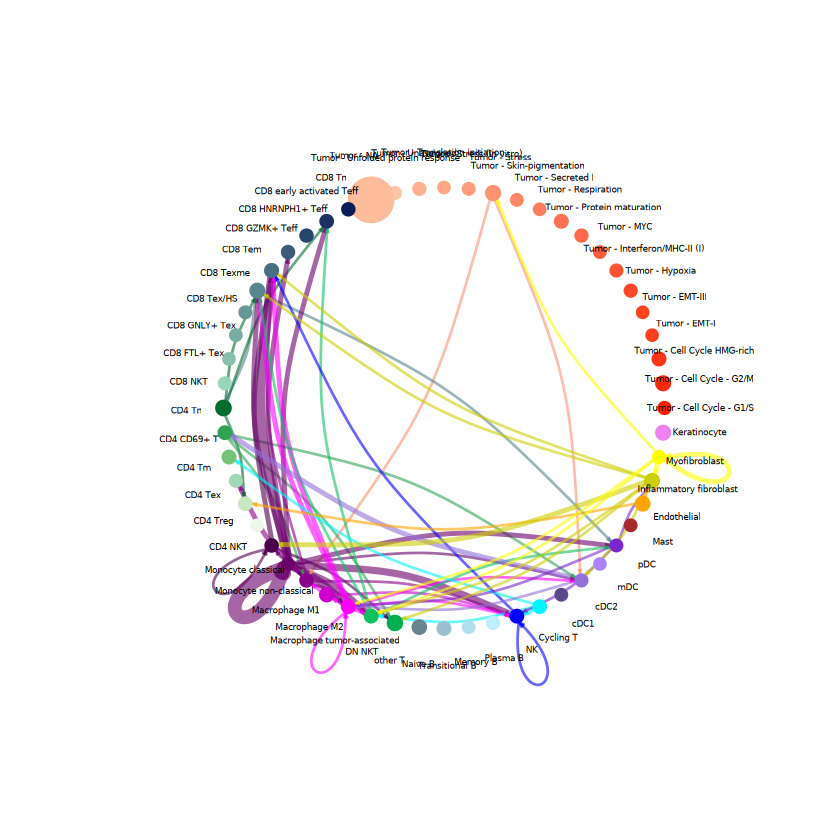

In [21]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_celltype_res/cell_communication_LR_results_subtype_plot_w_zero_means_all_ixns.pdf',
     #  width = 11, height = 12)

print(netVisual_circle(weight_mat, vertex.weight = all_ixns_node_size,
                 color.use = subtype_cols, weight.scale = T, edge.weight.max = max_edge_weight,
                       vertex.weight.max = max_node_size, vertex.label.cex=0.4, label.edge= F, 
                      title.name = 'all interactions, 93 total interactions'))

#dev.off()

### 2. Plot mDC high interactions

In [22]:
### for mDC high interactions
obj.RNA.mDChigh <- subset(obj.RNA, subset = is_mDC_high == 1)
mDChigh_ixns_node_size <- get_node_size(obj.RNA.mDChigh, names(subtype_cols))
mDChigh_ixns_weights <- get_edge_weights(mDC_high_ixns$interacting_cells, names(subtype_cols))
mDChigh_weight_mat = data.matrix(mDChigh_ixns_weights)

Loading required package: Seurat

Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode



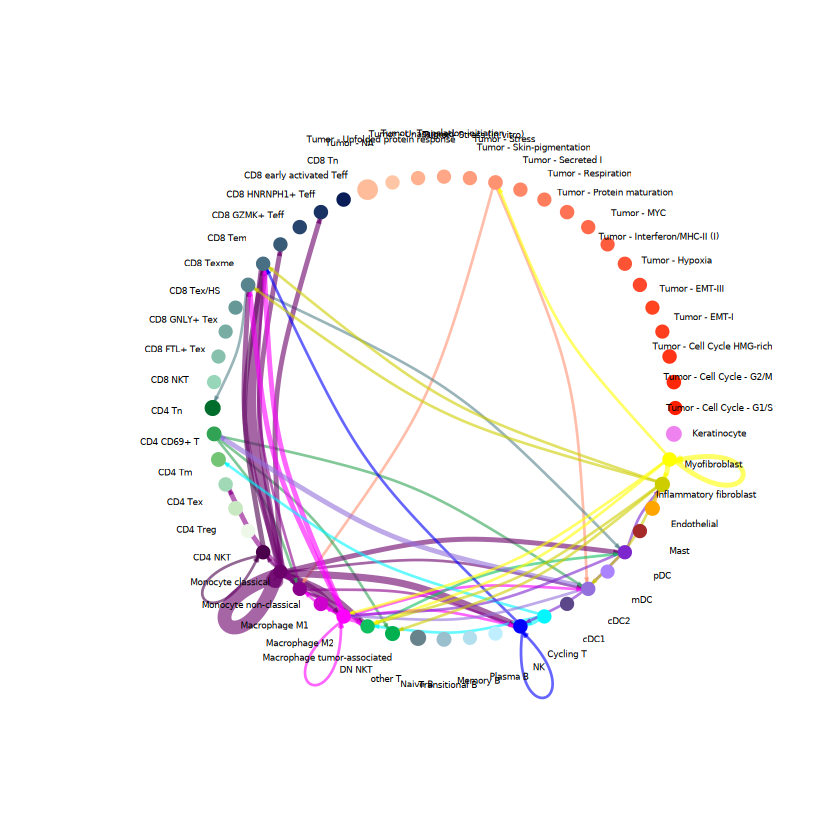

In [25]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_subtype_res/cell_communication_LR_results_subtype_plot_w_zero_means_mregDChigh_ixns.pdf',
#width = 11, height = 12)

print(netVisual_circle(mDChigh_weight_mat, vertex.weight = mDChigh_ixns_node_size,
                 color.use = subtype_cols, weight.scale = T, edge.weight.max = max_edge_weight,
                       vertex.weight.max = max_node_size, vertex.label.cex=0.4, label.edge= F, 
                      title.name = 'mDC high interactions'))

#dev.off()

### 3. Plot mDC low interactions 

In [58]:
### for mDC low interactions
obj.RNA.mDClow <- subset(obj.RNA, subset = is_mDC_high == 0)
mDClow_ixns_node_size <- get_node_size(obj.RNA.mDClow, names(subtype_cols))
mDClow_ixns_weights <- get_edge_weights(mDC_low_ixns$interacting_cells, names(subtype_cols))
mDClow_weight_mat = data.matrix(mDClow_ixns_weights)

In [59]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_subtype_res/cell_communication_LR_results_subtype_plot_w_zero_means_mregLow_ixns.pdf',
    #  width = 11, height = 12)

print(netVisual_circle(mDClow_weight_mat, vertex.weight = mDClow_ixns_node_size,
                 color.use = subtype_cols, weight.scale = T, edge.weight.max = max_edge_weight,
                       vertex.weight.max = max_node_size, vertex.label.cex=0.4, label.edge= F, 
                      title.name = 'mDC low interactions, 10 interactions'))

#dev.off()

png 
  2

### B. Option 2 results

In [22]:
#merge csvs together 
all_ixn_summary <- read.csv('/home/cbw3/data/figure_generation/Figure6/ccc_LR_results_no_zero_means_subtype_1.csv', 
                           row.names = 'X')

num_vec <- c('2', '3', '4', '5', '6', '7', '8', '9', '10')

path_head <- '/home/cbw3/data/figure_generation/Figure6/ccc_LR_results_no_zero_means_subtype_'
path_end <- '.csv'

for(num in num_vec) {
    ixn_summary_subset <- read.csv(paste0(path_head, num, path_end), row.names = 'X')
    all_ixn_summary <- rbind(all_ixn_summary, ixn_summary_subset)
}

In [24]:
write.csv(all_ixn_summary, './mDC_proportion_analysis/cell_communication_LR_results_subtype_no_zero_means.csv')

#### Cutoffs
- mDC high: sig_mean_coeff > 0
- pval < 0.05
- filter out interactions where it is expressed in less than 6 samples for mDC high or low 

In [29]:
all_ixn_summary <- read.csv('./mDC_proportion_analysis/cell_communication_LR_results_subtype_no_zero_means.csv')

### Filter interactions

In [30]:
ixn_summary_filt <- all_ixn_summary %>% filter(sig_mean_coeff != 'NA' | sig_mean_pval != 'NA')

In [31]:
print(paste0("Total number of interactions: ", dim(all_ixn_summary)[1]))
print(paste0("Number of interactions with results: ", dim(ixn_summary_filt)[1]))

[1] "Total number of interactions: 198364"
[1] "Number of interactions with results: 27044"


In [32]:
#further filter by pvalue and 6 as the minimum number of samples
ixn_summary_filt <- ixn_summary_filt %>% filter(sig_mean_pval < 0.05, num_nonzero_mDC_high  >= 6, num_nonzero_mDC_low >= 6)

print(paste0("Number of interactions after applying cutoffs: ", dim(ixn_summary_filt)[1]))

[1] "Number of interactions after applying cutoffs: 182"


In [33]:
#filter by mDC high or low 
mDC_low_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff < 0)
mDC_high_ixns <- ixn_summary_filt %>% filter(sig_mean_coeff > 0)

print(paste0("Number of mDC low interactions: ", dim(mDC_low_ixns)[1]))
print(paste0("Number of mDC high interactions: ", dim(mDC_high_ixns)[1]))

[1] "Number of mDC low interactions: 91"
[1] "Number of mDC high interactions: 91"


In [34]:
print(paste0("Number of interactions after applying cutoffs: ", dim(ixn_summary_filt)[1]))

[1] "Number of interactions after applying cutoffs: 182"


### 1. Plot all interactions

In [39]:
#obj.RNA <- readRDS('/net/bmc-lab5/data/kellis/group/scCancer2023/objects_for_DC_manuscript/for_public/1_RNA_all.rds')
all_ixns_node_size <- get_node_size(obj.RNA, names(subtype_cols))
all_ixns_weights <- get_edge_weights(ixn_summary_filt$interacting_cells, names(subtype_cols))
weight_mat = data.matrix(all_ixns_weights)

In [40]:
max_node_size = max(all_ixns_node_size)
max_edge_weight = max(weight_mat)

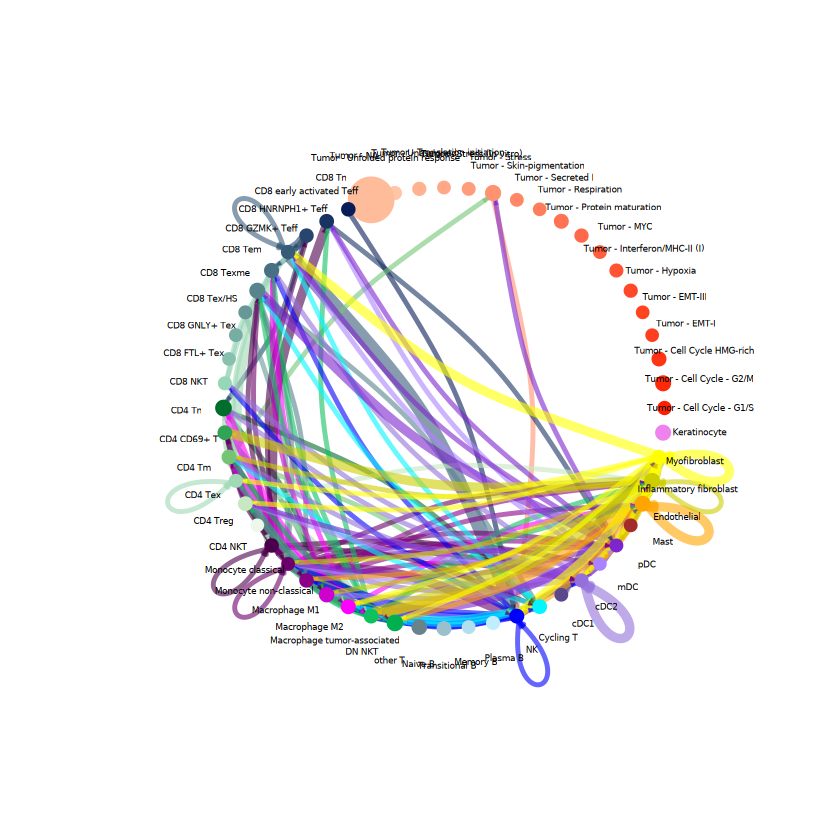

In [43]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_subtype_res/cell_communication_LR_results_subtype_plot_no_zero_means_all_ixns.pdf',
      #width = 11, height = 12)

print(netVisual_circle(weight_mat, vertex.weight = all_ixns_node_size,
                 color.use = subtype_cols, weight.scale = T, edge.weight.max = max_edge_weight,
                       vertex.weight.max = max_node_size, vertex.label.cex=0.4, label.edge= F, 
                      title.name = 'all interactions, total number: 182'))

#dev.off()

### 2. Plot mDC high interactions

In [46]:
### for mDC high interactions
obj.RNA.mDChigh <- subset(obj.RNA, subset = is_mDC_high == 1)
mDChigh_ixns_node_size <- get_node_size(obj.RNA.mDChigh, names(subtype_cols))
mDChigh_ixns_weights <- get_edge_weights(mDC_high_ixns$interacting_cells, names(subtype_cols))
mDChigh_weight_mat = data.matrix(mDChigh_ixns_weights)

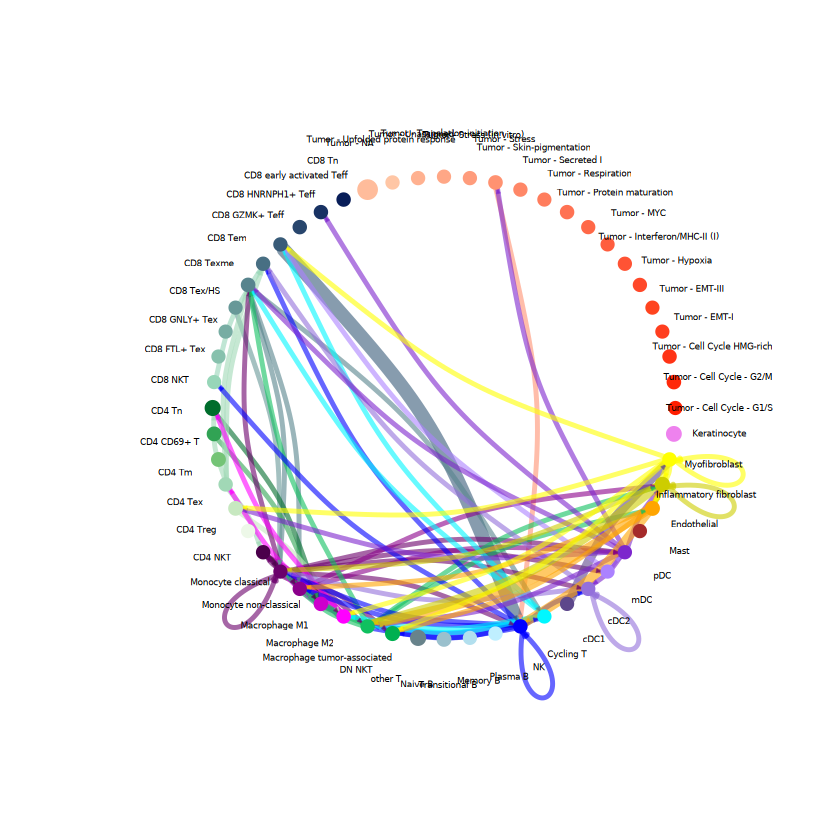

In [48]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_subtype_res/cell_communication_LR_results_subtype_plot_no_zero_means_mregHigh_ixns.pdf',
 #     width = 11, height = 12)

print(netVisual_circle(mDChigh_weight_mat, vertex.weight = mDChigh_ixns_node_size,
                 color.use = subtype_cols, weight.scale = T, edge.weight.max = max_edge_weight,
                       vertex.weight.max = max_node_size, vertex.label.cex=0.4, label.edge= F, 
                      title.name = 'mDC high interactions, n = 81'))

#dev.off()

### 3. mDC low interactions

In [49]:
### for mDC low interactions
obj.RNA.mDClow <- subset(obj.RNA, subset = is_mDC_high == 0)
mDClow_ixns_node_size <- get_node_size(obj.RNA.mDClow, names(subtype_cols))
mDClow_ixns_weights <- get_edge_weights(mDC_low_ixns$interacting_cells, names(subtype_cols))
mDClow_weight_mat = data.matrix(mDClow_ixns_weights)

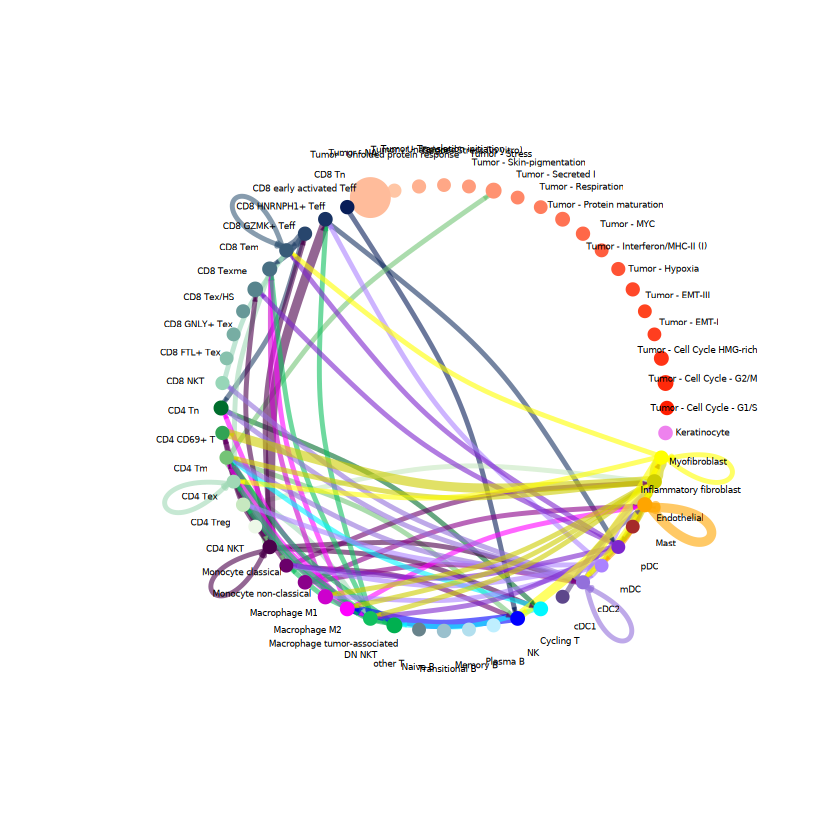

In [51]:
#pdf('./mDC_proportion_analysis/cell_communication_LR_subtype_res/cell_communication_LR_results_subtype_plot_no_zero_means_mregLow_ixns.pdf',
     # width = 11, height = 12)

print(netVisual_circle(mDClow_weight_mat, vertex.weight = mDClow_ixns_node_size,
                 color.use = subtype_cols, weight.scale = T, edge.weight.max = max_edge_weight,
                       vertex.weight.max = max_node_size, vertex.label.cex=0.4, label.edge= F, 
                      title.name = 'mDC low interactions, n = 81'))

#dev.off()

In [52]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /net/bmc-lab5/data/kellis/users/cbw3/conda/envs/r-kernel/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] Seurat_4.3.0.1      SeuratObject_5.0.1  sp_2.1-3           
 [4] CellChat_1.6.1      bigmemory_4.6.4     Biobase_2.58.0     
 [7] BiocGenerics_0.44.0 ggplot2_3.5.0       igraph_2.0.3       
[10] dplyr_1.1.4        

loaded via a namespace (and not attached):
  [1] uuid_1.2-0